$$
\newcommand{\parens}[1]{\mathopen{}\left(#1\right)\mathclose{}}
\newcommand{\bracks}[1]{\mathopen{}\left[#1\right]\mathclose{}}
\newcommand{\braces}[1]{\mathopen{}\left\{#1\right\}\mathclose{}}
\newcommand{\abs}[1]{\mathopen{}\left\lvert#1\right\rvert\mathclose{}}
\newcommand{\norm}[1]{\mathopen{}\left\lVert#1\right\rVert\mathclose{}}
\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\mat}[1]{\mathbf{#1}}
\newcommand{\tpose}[1]{#1^T}
\newcommand{\inv}[1]{#1^{-1}}
\newcommand{\Matrix}[1]{
  \begin{bmatrix}
    #1
  \end{bmatrix}
}
\newcommand{\seq}[1]{1, 2, \ldots, #1}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\mper}{\,\text{.}}
\newcommand{\mcom}{\,\text{,}}
$$

(yelp)=
# Farmer's Fridge Yelp Reviews Analysis

## Summary

Using data from 173 Yelp reviews for three major fridge locations, I examined trends like average ratings over time, item popularity, and common phrases mentioned in reviews.
The results show that, pre-pandemic:

1. The airport location had more and, on average, better ratings while it was active
2. Salad popularity decreased over time while bowl and sandwich popularities increased, but salads are still by far the most popular type of item

Common positive phrases include "healthy", "good", and "fresh", while analysis of negative reviews suggests price and portion sizes factored into their low ratings.

```{note}
You can run and modify the code on this page Jupyter Notebook style, but without leaving the page!
Hover over the {fa}`rocket` launch button at the top of the page, then click the {guilabel}`Live Code` button.
Once you see "Launching from mybinder.org: ready", you can run code cells.
Refresh the page to revert to the original view.
```

## Data Source

I scraped Yelp reviews using the Selenium package on 6/20/2021.
Data include rating (1 out of 5 stars), the main text of the review, and metadata like the the number of Yelp reviews a user has given or the number of people who found a review useful.
Each review constitutes a row in the `yelp.csv` file, with each piece of data (rating, text, etc.) as a separate column.

I scraped three different Chicago fridges.
I found the locations by manually navigating Yelp's website and searching for "farmer's fridge" in Chicago and selecting fridges with > 10 reviews.
The three fridges have [93 reviews](https://www.yelp.com/biz/farmers-fridge-chicago-13), [23 reviews](https://www.yelp.com/biz/farmers-fridge-chicago-14), and [57 reviews](https://www.yelp.com/biz/farmers-fridge-chicago-87) for a total of 173 reviews.
Two fridges are located in The Loop, while the third location with 57 reviews is located in O'Hare International Airport.

My complete code to scrape the reviews can be toggled below, but is not the main focus of this writeup.


````{toggle}
```python
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import csv

def scrape_reviews(yelp_url, sleep_time=1):
    """Retrieve all text data from reviews, including star rating.
    Sleep between pages of reviews so the html loads before accessing data."""
    browser = webdriver.Firefox()
    browser.get(yelp_url)

    all_reviews = []
    more_pages_exist = True
    while more_pages_exist:
        time.sleep(sleep_time)  # Wait for page to load
        reviews = get_reviews_on_page(browser)
        all_reviews.extend(reviews)
        click_succeeded = click_on_next_page(browser)
        if not click_succeeded:
            more_pages_exist = False
    return all_reviews

def get_reviews_on_page(browser):
    """Extract reviews on a Yelp page."""
    reviews = []
    review_num = 1
    more_reviews_exist = True
    while more_reviews_exist:
        try:
            review = browser.find_element_by_xpath(
                "/html/body/div[2]/div[2]/yelp-react-root/div/div[3]/div/div"
                + "/div[2]/div/div[1]/div[2]/section[2]/div[2]/div/ul"
                + "/li[" + str(review_num) + "]"
                + "/div"
            )
            rating = browser.find_element_by_xpath(
                "/html/body/div[2]/div[2]/yelp-react-root/div/div[3]/div/div/"
                + "div[2]/div/div[1]/div[2]/section[2]/div[2]/div/ul"
                + "/li[" + str(review_num) + "]"
                + "/div/div[2]/div/div[1]/span/div"
            ).get_attribute('aria-label')

            reviews.append(rating + "\n" + review.text)
            review_num += 1
        except NoSuchElementException:  # No more reviews on page
            more_reviews_exist = False
    return reviews

def click_on_next_page(browser):
    """Click on the next page of Yelp reviews, if it exists. Returns
    whether the next page exists."""
    try:
        next_page_button = browser.find_element_by_css_selector(
            '.next-link'
        )
        next_page_button.click()
        return True
    except NoSuchElementException:
        return False

def write_to_csv(file_name, reviews, append=False, location=''):
    """Write the following data as columns in a csv file:
        - rating (1 to 5 scale)
        - reviewer data: name, location, number of friends, number of
            reviews, and number of photos
        - review data: date of review, updated or not, review text,
            number of people who found the review useful, funny, and cool
    """
    mode = 'a' if append else 'w'
    with open(file_name, mode, newline='') as file:
        writer = csv.writer(file)

        if not append:
            header = [
                'rating',
                'name',
                'elite',
                'reviewer_location',
                'n_friends',
                'n_reviews',
                'n_photos',
                'review_photos',
                'date',
                'updated',
                'text',
                'n_useful',
                'n_funny',
                'n_cool'
            ]
            if location:
                header.append('restaurant_location')
            writer.writerow(header)

        for review in reviews:
            row = process_review(review)
            if location:
                row.append(location)
            writer.writerow(row)

def process_review(review):
    """Process the structure of a Yelp review line by line into a row
    to be appended by the `write_to_csv()` function."""
    lines = review.split('\n')
    rating = lines.pop(0)[0]

    # Reviewer data
    name = lines.pop(0)
    if is_elite(lines[0]):
        elite = 'True'
        lines.pop(0)
    else:
        elite = 'False'
    location = lines.pop(0)
    n_friends = lines.pop(0)
    n_reviews = lines.pop(0)
    if is_int(lines[0]):
        n_photos = lines.pop(0)
    else:
        n_photos = 0

    # Review data
    date = lines.pop(0)
    if is_updated_review(lines[0]):
        updated = 'True'
        lines.pop(0)
    else:
        updated = 'False'
    if has_photos(lines[0], single=True):
        review_photos = '1'
        lines.pop(0)
    elif has_photos(lines[0], single=False):
        review_photos = strip_nonint(lines[0], 'photos')
        lines.pop(0)
    else:
        review_photos = 0
    end_of_review_text = find_end_of_review_text(lines)
    text = '\n'.join(lines[:end_of_review_text])
    n_useful = strip_nonint(lines[end_of_review_text], 'Useful')
    n_funny = strip_nonint(lines[end_of_review_text + 1], 'Funny')
    n_cool = strip_nonint(lines[end_of_review_text + 2], 'Cool')

    row = [
        rating,
        name,
        elite,
        location,
        n_friends,
        n_reviews,
        n_photos,
        review_photos,
        date,
        updated,
        text,
        n_useful,
        n_funny,
        n_cool
    ]
    return row

def find_end_of_review_text(lines):
    """Find which line the main text of a review ends."""
    for i in range(len(lines) - 2):
        line1 = lines[i]
        line2 = lines[i + 1]
        line3 = lines[i + 2]
        if (line1.startswith('Useful')
                and line2.startswith('Funny')
                and line3.startswith('Cool')):
            return i

    print("Warning: no expected end of text found.")

def is_elite(string):
    """Determine if given string is an elite Yelp user."""
    return string.startswith("Elite")

def is_int(string):
    """Determine if given string is an integer."""
    try:
        int(string)
        return True
    except ValueError:
        return False

def has_photos(string, single=False):
    """Determine if given string ends in 'photo' or 'photos'."""
    if single:
        return string.endswith('photo')
    else:
        return string.endswith('photos')

def is_updated_review(string):
    """Determine if given string indicates an updated Yelp review."""
    return string == "Updated review"

def strip_nonint(string, word_to_strip):
    """Strip words and spaces from a string, keeping non-integer parts
    after stripping. If the remaining piece is not an integer, return '0'.
    So, 'Useful 12' becomes '12' while 'Useful' becomes '0'."""
    stripped = string.strip(word_to_strip).strip(' ')
    if is_int(stripped):
        return stripped
    else:
        return '0'


if __name__ == '__main__':
    url_location_pairs = [
        ('https://www.yelp.com/biz/farmers-fridge-chicago-13', 'The Loop 1'),
        ('https://www.yelp.com/biz/farmers-fridge-chicago-14', 'The Loop 2'),
        ('https://www.yelp.com/biz/farmers-fridge-chicago-87', "O'Hare Airport"),
    ]
    file_name = 'yelp.csv'

    counter = 1  # Determine when to write to a new file or append to existing one
    for url, location in url_location_pairs:
        print(f"Scraping url number {counter}")
        reviews = scrape_reviews(url)
        if counter == 1:
            write_to_csv(file_name, reviews, append=False, location=location)
        elif counter > 1:
            write_to_csv(file_name, reviews, append=True, location=location)
        counter += 1
```
````

## Data Cleaning and Exploration

Let’s load in the data and examine it:

In [1]:

import pandas as pd

df = pd.read_csv("yelp.csv")
df.head()

,rating,name,elite,reviewer_location,n_friends,n_reviews,n_photos,review_photos,date,updated,text,n_useful,n_funny,n_cool,business_location
0,5,Josh C.,True,"Chicago, IL",215,22,129,9,1/9/2021,False,We received a Farmer's Fridge delivery straigh...,0,0,1,The Loop 1
1,5,Jim Z.,False,"Napa, CA",0,25,8,0,5/19/2021,False,"Repeat buyer... awesome food, great service......",0,0,0,The Loop 1
2,5,Kathy L.,False,"New Berlin, WI",0,2,0,0,4/2/2021,False,So happy I found Farmers Fridge in MKE airport...,0,0,0,The Loop 1
3,5,Regina X.,True,"Seattle, WA",521,220,432,0,9/1/2019,False,The business stock photos did not prepare me f...,0,0,0,The Loop 1
4,1,Alice J.,False,"Oak Park, IL",0,23,1,0,8/14/2020,False,$8 for a salad in a jar.\n$8.\nThis is ridicul...,0,3,0,The Loop 1


The important variables that will be used for this analysis are:

1. `rating`: an integer rating between 1 (worst) and 5 (best)
2. `date`: the date the review was posted on Yelp
3. `text`: the main contents of the review
4. `business_location`: the location of the fridge

The others are not used, but some ideas how of how to use them are sketched in § [](yelp-future).

It's much more convenient to work with datetime objects, so let's convert them:

In [2]:

df.date = pd.to_datetime(df.date)

Now we can easily group reviews by year.
Also grouping by fridge (i.e. business) location, we can count the number of reviews posted at each location in a given year:

In [3]:

grouped_by_year_and_loc = df.groupby([df.date.dt.year, df.business_location])
annual_counts = grouped_by_year_and_loc.rating.agg("count").unstack()
annual_counts

business_location,O'Hare Airport,The Loop 1,The Loop 2
date,,,
2013,NaN,13.0,NaN
2014,NaN,21.0,NaN
2015,NaN,22.0,NaN
2016,NaN,19.0,5.0
2017,10.0,5.0,6.0
2018,24.0,5.0,6.0
2019,19.0,3.0,5.0
2020,4.0,2.0,1.0
2021,NaN,3.0,NaN


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Number of Annual Reviews')]

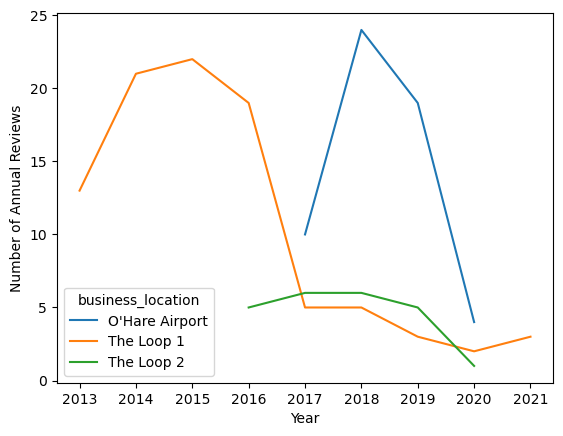

In [4]:

ax = annual_counts.plot()
ax.set(xlabel="Year", ylabel="Number of Annual Reviews")

The first Loop location seems to have been one of the first fridges, with reviews available in the same year the company was founded.
The number of reviews per year begins to decline around 2016, coinciding with the opening up of the second Loop location.
In 2017, a fridge location in O'Hare international airport opened up and became relatively popular.
In 2020, when the effects of the COVID-19 pandemic drastically altered lives of Chicago residents, the number of reviews also drastically declined, continuing into 2021.

If we're interested in annual trends over time, it may helpful to combine the two Loop locations to avoid aggregates from only 5 or fewer reviews:

In [5]:

import numpy as np


def combine_loop_locations(locations):
    combined_locations = []
    for loc in locations:
        if loc.startswith("The Loop"):
            combined_locations.append("The Loop")
        else:
            combined_locations.append(loc)
    return combined_locations


df["combined_location"] = combine_loop_locations(df.business_location)
np.unique(df.combined_location)

array(["O'Hare Airport", 'The Loop'], dtype=object)


## Exploratory Data Analysis

This section examines a few specific questions, focusing on graphical presentation and inuition rather than formal statistical tests.
These analyses can help inform what avenues Farmer's Fridge could look into in the future and serve as a foundation for more detailed analyses later.

### Ratings Over Time

A plot of annual ratings over time, grouped by location, can be constructed by grouping by the relevant variables and invoking the `.plot()` method.
In addition, I'll overlay points with sizes proportional to the number of reviews.
This allows us to quickly weight large points more than small points.
This is important especially for 2020 and 2021 when there is very little data;
for example, the 5/5 rating data for the Loop locations in 2021 is only based on 3 reviews.

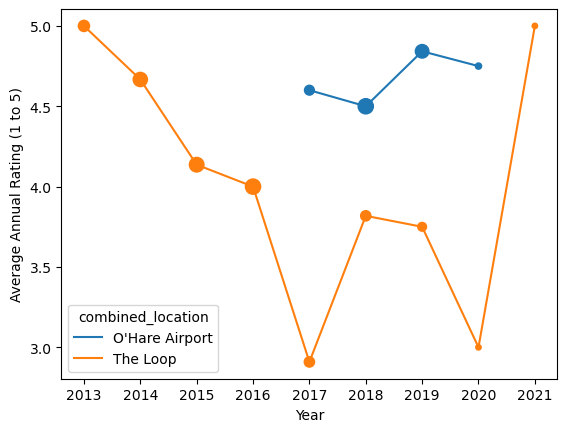

In [6]:

import matplotlib.pyplot as plt

grouped_by_year_and_loc = df.groupby([df.date.dt.year, df.combined_location])
annual_ratings = grouped_by_year_and_loc.rating.agg("mean").unstack()
annual_counts = grouped_by_year_and_loc.rating.agg("count").unstack()

ax = annual_ratings.plot()
ax.set(xlabel="Year", ylabel="Average Annual Rating (1 to 5)")
for i, loc in enumerate(annual_ratings.columns):
    col = "C" + str(i)
    point_sizes = [5 * count for count in annual_counts[loc]]
    ax.scatter(annual_ratings.index, annual_ratings[loc], s=point_sizes, c=col)

There appears to have been a steady decline in rating throughout 2016.
In 2017, the Loop location's rating fell substantially but the introduction of the O'Hare location was a success.
The Loop location rebounded somewhat and the O'Hare location continued to see success, until the pandemic hit, drastically lowering the number of ratings available in 2020 and 2021.

### What Items are Popular?

A simple analysis assumes a correlation between the number of mentions of an item and its popularity.
I've grouped the items like Farmer's Fridge's [website menu](https://www.farmersfridge.com/menu), as well as words that are likely to belong in that grouping. Terms synonymous with salad, for example, are

In [7]:

salads = [
    "Smoked Cheddar Cobb Salad",
    "Buffalo Chicken Ranch Salad",
    "Elote Salad",
    "North Napa Salad",
    "Grilled Chicken Caesar Salad",
    "Southwest Salad with Chipotle Chicken",
    "Green Goddess Salad",
    "Greek Salad",
    "Salad",
]

The other groupings are defind as follows:

In [8]:

bowls = [
    "Apple Cinnamon Oats",
    "Falafel Bowl",
    "Pesto Pasta Bowl",
    "Thai Noodle Bowl",
    "Burrito Bowl",
    "Red Chile Braised Pork Bowl by Rick Bayless",
    "Pineapple Coconut Chia Pudding",
    "Berries & Granola Greek Yogurt",
    "Almond Butter Oats Bowl",
    "Chickpea Tikka Masala",
    "Chicken Tikka Masala",
    "Grilled Chicken & Veggie Bowl",
    "Truffle Couscous with Chicken" "Bowl",
    "oats",
    "yogurt",
]
sandwiches = [
    "Italian Turkey Wrap",
    "Turkey, Apple & White Cheddar Wrap",
    "Sandwich",
    "Wrap",
]
snacks = [
    "White Cheddar Cheese",
    "Cookie Dough Bites",
    "Dark Chocolate Trail Mix",
    "Chips & Guac",
    "snack",
    "trail",
    "dough",
]
proteins = [
    "Falafel",
    "Grilled Chicken",
]
drinks = [
    "La Colombe Vanilla Draft Latte",
    "La Colombe Triple Draft Latte",
    "Brew Dr. Kombucha Love",
    "Spindrift Raspberry Lime",
    "drink",
]

With the item groups defined, let's count unique mentions of each group:

In [9]:


def count_item_mentions(reviews, item_group):
    """Compute percentage of times an item in `item_group` is mentioned
    in a review."""
    count = 0
    for text in reviews:
        text = text.lower()
        for item in item_group:
            item = item.lower()
            if item in text:
                count += 1
                break
    return count / len(reviews)


item_mention_counts = {
    "salads": count_item_mentions(df.text, salads),
    "bowls": count_item_mentions(df.text, bowls),
    "sandwiches": count_item_mentions(df.text, sandwiches),
    "snacks": count_item_mentions(df.text, snacks),
    "proteins": count_item_mentions(df.text, proteins),
    "drinks": count_item_mentions(df.text, drinks),
}
item_mention_counts

{'salads': 0.7052023121387283,
 'bowls': 0.10404624277456648,
 'sandwiches': 0.07514450867052024,
 'snacks': 0.10982658959537572,
 'proteins': 0.023121387283236993,
 'drinks': 0.005780346820809248}

[Text(0.5, 0, 'Fraction of times mentioned in a review')]

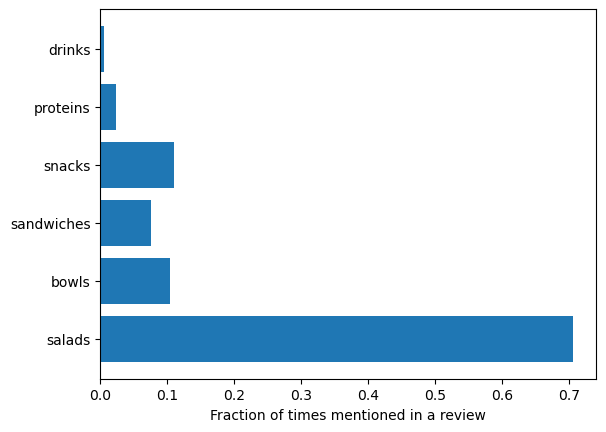

In [10]:

fig, ax = plt.subplots()
ax.barh(list(item_mention_counts.keys()), list(item_mention_counts.values()))
ax.set(xlabel="Fraction of times mentioned in a review")

Salads are the overwhelming favorite.
Have these trends changed over time?
Below is the annual share for each item type, i.e. the fraction of times an item was mentioned in a review for a given year.
Weighting by total number of reviews that year is again used.

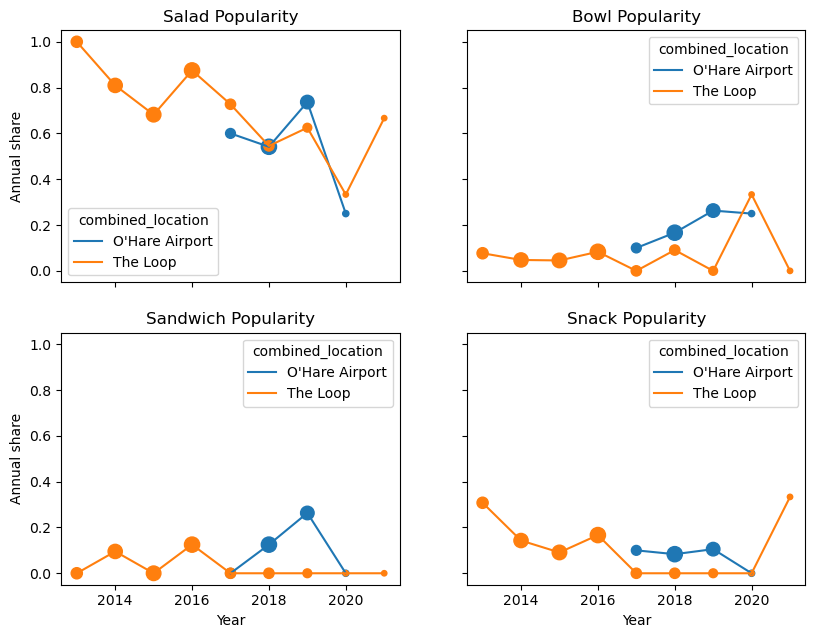

In [11]:


def annual_item_share_plot(ax, item_group, title):
    annual_share = grouped_by_year_and_loc.text.apply(
        count_item_mentions, item_group=item_group
    ).unstack()
    annual_share.plot(ax=ax)
    ax.set(xlabel="Year", ylabel="Annual share", title=title)
    for i, loc in enumerate(annual_counts.columns):
        col = "C" + str(i)
        point_sizes = [5 * count for count in annual_counts[loc]]
        ax.scatter(annual_share.index, annual_share[loc], s=point_sizes, c=col)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9.6, 7.2), sharex=True, sharey=True)
annual_item_share_plot(axs[0][0], salads, "Salad Popularity")
annual_item_share_plot(axs[0][1], bowls, "Bowl Popularity")
annual_item_share_plot(axs[1][0], sandwiches, "Sandwich Popularity")
annual_item_share_plot(axs[1][1], snacks, "Snack Popularity")

Salad popularity has been decreasing, but still has the largest share.
Bowl popularity seems to have the opposite trend, though still have a smaller share.
Sandwiches seem popular at airports, with a sudden drop in 2020 (perhaps due to the pandemic, as sandwiches are not usually eaten with utensils?)
Finally, snacks were initially popular (perhaps because of vending machine familiarity?) but have somewhat declined, except for 2021 where there are only 3 data points.

### What Phrases are Common?

We can answer this question with more sophisticated language processing.
Using NLTK, the Natural Language Toolkit, we can parse out individual words in a string of unstructured text, or more generally ngrams that contain n words strung together.
Before any of that, let's define a function that combines all the reviews in the `df.text` column of a dataframe:

In [12]:


def combine_review_text(df):
    review_text = ""
    for text in df.text:
        review_text += text + "\n" * 3
    return review_text


text = combine_review_text(df)
print(text[:1200])

We received a Farmer's Fridge delivery straight to our doors! We got a text when the driver was close and when the delivery was made. It was so easy and super convenient.

Their menu includes everything from salads to breakfast items to dinner plates and snacks. We received a variety and not only was it delicious, it was healthy and filling! Salads are typically not our first choice, but we were so impressed with how much flavor was packed into each one and am already craving them again!

We have tried other meal delivery services but were impressed with Farmer's Fridge the most. The convenience of the order, the ease of preparing the meal, and the overall quality and healthy options puts them above the competition. We can't wait to try more of their menu! Already eyeing the Buffalo Mac & Cheese and the Enchilada Roja plates......
See all photos from Josh C. for Farmer's Fridge


Repeat buyer... awesome food, great service... highly recommend!!! AAAA ++++
The salads are fresh and very 

Next, let's import `nltk` and get a list of words.
Technically in language processing terms, we are extracting *tokens*, since objects like punctuation are retained.
It's also useful to drop the most common words like "to", "then", and "the" using `nltk`'s library of English stop words and convert everything to lowercase for simplicity (must download stopwords and punk):

In [13]:


import nltk

nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
words = nltk.word_tokenize(text)
filtered_lowercase_words = []
for word in words:
    word = word.lower()
    if word not in stop_words:
        filtered_lowercase_words.append(word)
filtered_lowercase_words[:12]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adam/projects/website/env/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adam/projects/website/env/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['received',
 'farmer',
 "'s",
 'fridge',
 'delivery',
 'straight',
 'doors',
 '!',
 'got',
 'text',
 'driver',
 'close']

The result is terse, but the meaning of sentences are maintained.

Now we're ready to count the most common words and display them.
I'll define functions for general ngrams for later use.
So even though it is overkill to use a "onegram" for just a list of words we already have, I will for generalizibility.

In [14]:

from nltk.util import ngrams


def count_ngrams(ngrams):
    """Return a dictionary of ngram, count pairs."""
    counts = {}
    for tuple in ngrams:
        if tuple in counts:
            counts[tuple] += 1
        else:
            counts[tuple] = 1
    return counts


def sort_dict_by_vals(dict):
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    return sorted_dict


def print_top_vals(ngram_counts, min_count, min_length):
    """Print ngrams with at least `min_count` counts and each component
    exceeds `min_length` in characters."""
    for ngram, count in ngram_counts.items():
        if each_elem_is_long_enough(ngram, min_length) and count >= min_count:
            print(ngram, count)


def each_elem_is_long_enough(tuple, min_length):
    for elem in tuple:
        if len(elem) < min_length:
            return False
    return True


word_counts = list(ngrams(filtered_lowercase_words, 1))
word_counts = sort_dict_by_vals(count_ngrams(word_counts))
print_top_vals(word_counts, min_count=50, min_length=3)

('great',) 50
('one',) 51
('like',) 53
('delicious',) 57
('farmer',) 60
('healthy',) 65
('good',) 66
('vending',) 77
('fridge',) 85
('salads',) 87
('machine',) 92
('fresh',) 97
("n't",) 100
('food',) 111
('salad',) 220


Unsurprisingly, salad is the most common word.
Positive words include "great", "like", "delicious", "healthy", "good", and "fresh".
Because the overall rating across all reviews is high, around 4.3, it's also unsurprising there are no negative words in the most frequent list.
We can repeat the above for bigrams and trigrams, which are strings of two and three words, respectively.

In [15]:

bigrams = list(ngrams(filtered_lowercase_words, 2))
bigram_counts = sort_dict_by_vals(count_ngrams(bigrams))
print_top_vals(bigram_counts, min_count=10, min_length=3)

("n't", 'wait') 10
('could', "n't") 10
('southwest', 'salad') 10
('napa', 'salad') 12
('revival', 'food') 13
('food', 'hall') 13
('salad', 'vending') 15
('vending', 'machines') 16
('farmers', 'fridge') 19
('vending', 'machine') 60


In [16]:

trigrams = list(ngrams(filtered_lowercase_words, 3))
trigram_counts = sort_dict_by_vals(count_ngrams(trigrams))
print_top_vals(trigram_counts, min_count=5, min_length=3)

('north', 'napa', 'salad') 5
('high', 'protein', 'salad') 5
('honey', 'mustard', 'dressing') 6
('salad', 'vending', 'machine') 13
('revival', 'food', 'hall') 13


These are less informative as they are not positive word plus noun.
Instead, they seem to be names of menu items or expected phrases, like "Farmer's Fridge" and "vending machine".

Since most of the reviews are positive, it's interesting to repeat the ngram analysis for negative reviews only.
Only about 10% of reviews have a rating of 2 or lower.

In [17]:

negative_text = combine_review_text(df[df.rating <= 2])
words = nltk.word_tokenize(negative_text)
filtered_lowercase_words = []
for word in words:
    word = word.lower()
    if word not in stop_words:
        filtered_lowercase_words.append(word)
filtered_lowercase_words[:12]

word_counts = list(ngrams(filtered_lowercase_words, 1))
word_counts = sort_dict_by_vals(count_ngrams(word_counts))
print_top_vals(word_counts, min_count=5, min_length=3)

('prices',) 5
('like',) 5
('revival',) 5
('hall',) 5
('back',) 5
('little',) 5
('open',) 5
('times',) 5
('lettuce',) 5
('got',) 6
('would',) 7
('vending',) 8
('lunch',) 8
('machine',) 13
("n't",) 13
('food',) 14
('salad',) 20


While we don't see obvious negative terms like "bad", we can infer from the given words that these reviewers didn't like the "prices", "little" [portions?], [available?] "times", etc.
Similarly from the bigrams and trigrams,

In [18]:

bigrams = list(ngrams(filtered_lowercase_words, 2))
bigram_counts = sort_dict_by_vals(count_ngrams(bigrams))
print_top_vals(bigram_counts, min_count=2, min_length=3)

('salad', 'vending') 2
('every', 'day') 2
('open', '9am') 2
('used', 'get') 2
('salad', 'portions') 2
('brown', 'lettuce') 2
('come', 'back') 3
('could', "n't") 3
('revival', 'food') 5
('food', 'hall') 5
('vending', 'machine') 7


In [19]:
trigrams = list(ngrams(filtered_lowercase_words, 3))
trigram_counts = sort_dict_by_vals(count_ngrams(trigrams))
print_top_vals(trigram_counts, min_count=2, min_length=3)

('salad', 'vending', 'machine') 2
('revival', 'food', 'hall') 5


we can infer things like these reviewers were not impressed by the salad portions or the vending machine (perhaps they were just not expecting one?).

(yelp-future)=
## Future Work

These analyses would benefit from more review data and more use of data already collected in reviews.
The Selenium web-scraping approach is very flexible and generalizable.
Future work can automate it to search for all fridge locations in Chicago and scrape all locations with 1 or more reviews.
It is also easy to extend this approach to other cities, like New York City.
I collected lots of metadata, like how many other reviews a given reviewer has posted or whether they've obtained the "Elite" Yelp user status.
In addition, it may be useful to take a more detailed look at reviews that have lots of engagement, measured by how many other Yelpers found the review useful, funny, and/or cool.

Additional data could be estimated from the variables collected, for example reviewer sex from an analysis of their names.
This could be useful information if Farmer's Fridge wanted to better target a particular demographic.
More in depth natural language processing could also be useful to improve the accuracy of the popularity metrics, e.g. salad popularity.
Rather than just looking at if "salad" was mentioned, analyzing the sentiment around that mention would give better information.